In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import pdb
import tensorflow as tf

In [3]:
##############################################################
#my adaboost

In [2]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1 ,-1])

In [87]:
class AdaBoost(object):
    def __init__(self):
        self.f = []
        pass
    
    def train(self, xtrain, ytrain, numIt = 3):
        xtrain = xtrain.astype(np.float)
        ytrain = ytrain.astype(np.float)
        f_err = np.inf
        w = np.ones(xtrain.shape[0]) / xtrain.shape[0]
        i = 0
        while i < numIt:
            # 求弱分类器，以及弱分类器的错误率，和结果
            weak_classifier, err, weak_result = self.get_weak_classifier(xtrain, ytrain, w)
            # 求弱分类器的权重
            alpha = 1.0 / 2.0 * np.log((1-err)/err)
            # 更新权值分布
            w = self.update_w(ytrain, weak_result, alpha, w)
            # 求强分类器，以及强分类器的误分类数和结果
            self.f.append({'alpha':alpha, 'weak_classifier':weak_classifier})
            f_err, f_result = self.pred_strong_classifier(xtrain, ytrain)
            
            i = 1 + i
            
    def update_w(self, ytrain, weak_result, alpha, w):
        w = w * np.exp(-1.0 * alpha * ytrain * weak_result)
        w = w / w.sum()
        return w
            
    def get_weak_classifier(self, xtrain, ytrain, w):
        #这里的弱分类有 x > v 和 x < v 产生
        weak_classifier = {'left':None, 'right':None, 'val':None, 'w': w, 'err':None}
        min_err = np.inf
#         best_split = None
        for xx in np.unique(xtrain):
            left_y = ytrain[xtrain <= xx]
            left_weight = w[xtrain <= xx]
            left_err = ((left_y != 1).astype(np.float) * left_weight).sum()
            right_y = ytrain[xtrain > xx]
            right_weight = w[xtrain > xx]
            right_err = ((right_y != -1).astype(np.float) * right_weight).sum()
            err = left_err + right_err
            if err < min_err:
                min_err = err
                #best_split = xx
                weak_classifier['val'] = xx
                weak_classifier['left'] = 1
                weak_classifier['right'] = -1
                weak_classifier['err'] = min_err
                
            left_y = ytrain[xtrain <= xx]
            left_weight = w[xtrain <= xx]
            left_err = ((left_y != -1).astype(np.float) * left_weight).sum()
            right_y = ytrain[xtrain > xx]
            right_weight = w[xtrain > xx]
            right_err = ((right_y != 1).astype(np.float) * right_weight).sum()
            err = left_err + right_err
            if err < min_err:
                min_err = err
#                 best_split = xx
                weak_classifier['val'] = xx
                weak_classifier['left'] = -1
                weak_classifier['right'] = 1
                weak_classifier['err'] = min_err
        result = self.pred_weak_classifier(xtrain, ytrain, weak_classifier)
        weak_classifier['result'] = result
        return weak_classifier, min_err, result
        pass
    
    def pred_weak_classifier(self, xtrain, ytrain, weak_classifier):
        result = []
        for xx in xtrain:
            if xx <= weak_classifier['val']:
                result.append(weak_classifier['left'])
            else:
                result.append(weak_classifier['right'])
#         result = [ for i in xtrain <= weak_classifier['val'] if i ]
        return result
        pass
    
    def pred_strong_classifier(self, xtrain, ytrain):
        f_err = 0
        f_result = []
        for xx, yy in zip(xtrain, ytrain):
            f_xx = 0.0
            for G in self.f:
                if xx <= G['weak_classifier']['val']:
                    f_xx = f_xx + G['alpha'] * G['weak_classifier']['left']
                else:
                    f_xx = f_xx + G['alpha'] * G['weak_classifier']['right']
            f_result.append(np.sign(f_xx))
            if f_xx * yy < 0:
                f_err  = f_err + 1
        return f_err, f_result
        pass
    
    def predict(self, xtest):
        f_xx = 0.0
        for G in self.f:
            if xtest <= G['weak_classifier']['val']:
                f_xx = f_xx + G['alpha'] * G['weak_classifier']['left']
            else:
                f_xx = f_xx + G['alpha'] * G['weak_classifier']['right']
        return np.sign(f_xx)

In [89]:
ada_clf = AdaBoost()
ada_clf.train(x, y, 3)
ada_clf.f

[{'alpha': 0.42364893019360172,
  'weak_classifier': {'err': 0.30000000000000004,
   'left': 1,
   'result': [1, 1, 1, -1, -1, -1, -1, -1, -1, -1],
   'right': -1,
   'val': 2.0,
   'w': array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])}},
 {'alpha': 0.64964149206513044,
  'weak_classifier': {'err': 0.21428571428571427,
   'left': 1,
   'result': [1, 1, 1, 1, 1, 1, 1, 1, 1, -1],
   'right': -1,
   'val': 8.0,
   'w': array([ 0.07142857,  0.07142857,  0.07142857,  0.07142857,  0.07142857,
           0.07142857,  0.16666667,  0.16666667,  0.16666667,  0.07142857])}},
 {'alpha': 0.75203869838813697,
  'weak_classifier': {'err': 0.18181818181818185,
   'left': -1,
   'result': [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1],
   'right': 1,
   'val': 5.0,
   'w': array([ 0.04545455,  0.04545455,  0.04545455,  0.16666667,  0.16666667,
           0.16666667,  0.10606061,  0.10606061,  0.10606061,  0.04545455])}}]

In [76]:
ada_clf.predict(5.01)

1.0

In [4]:
##############################################################

In [1]:
##############################################################
#my cart

In [7]:
x=np.array([  
[0,0,0,0,8],  
[0,0,0,1,3.5],  
[0,1,0,1,3.5],  
[0,1,1,0,3.5],  
[0,0,0,0,3.5],  
[1,0,0,0,3.5],  
[1,0,0,1,3.5],  
[1,1,1,1,2],  
[1,0,1,2,3.5],  
[1,0,1,2,3.5],  
[2,0,1,2,3.5],  
[2,0,1,1,3.5],  
[2,1,0,1,3.5],  
[2,1,0,2,3.5],  
[2,0,0,0,10],  
]);

y = np.array([  
[1],  
[0],  
[1],  
[1],  
[0],  
[0],  
[0],  
[1],  
[1],  
[1],  
[1],  
[1],  
[1],  
[1],  
[1],  
]) 

In [121]:
class CartTree(object):
    def __init__(self, min_num_leafnode = 1, min_gini = 0.05):
#         assert xtrain.shape[0] == ytrain.shape[0]
        self.min_num_leafnode = min_num_leafnode
        self.min_gini = min_gini
        pass
    
    def train(self, xtrain, ytrain):
        self.tree = self.maketree(xtrain, ytrain)
            
    def gini(self, ytrain):
        uni_y = np.unique(ytrain)
        gn = 1.0
        for i in uni_y:
            num_i = ytrain[ytrain == i].shape[0] * 1.0 / ytrain.shape[0]
            gn = gn - num_i *  num_i
        return gn
    
    def node_class(self, ytrain):
        most = -np.inf
        most_label = -np.inf
        uni_y = np.unique(ytrain)
        for l in uni_y:
            num_l = ytrain[ytrain == l].shape[0]
            if num_l > most:
                most = num_l
                most_label = l
        return most_label
        pass
    
    def split_sample(self, feat, val, xtrain, ytrain):
        left_x  = xtrain[xtrain[:, feat] <= val]
        left_y  = ytrain[xtrain[:, feat] <= val]
        right_x = xtrain[xtrain[:, feat] >  val]
        right_y = ytrain[xtrain[:, feat] >  val]
        return left_x, left_y, right_x, right_y
    
    def choose_feat_val(self, xtrain, ytrain):
        m,n = xtrain.shape
        bestFeat = None
        bestVal = None
        best_gini = np.inf
        for featIndex in range(n):
            uni_i_x = np.unique(xtrain[:, featIndex])
            for sptval in uni_i_x:
                left_x, left_y, right_x, right_y = self.split_sample(featIndex, sptval, xtrain, ytrain)
                left_gini  = self.gini(left_y)
                right_gini = self.gini(right_y)
                sum_gini = left_y.shape[0] * 1.0 / ytrain.shape[0] *  left_gini + \
                          right_y.shape[0] * 1.0 / ytrain.shape[0] * right_gini
                if sum_gini < best_gini:
                    best_gini = sum_gini
                    bestFeat = featIndex
                    bestVal = sptval
        return bestFeat, bestVal
    
    def maketree(self, xtrain, ytrain):
        tree = {}
        tree['gini'] = self.gini(ytrain)
        print tree['gini']
        tree['class'] = self.node_class(ytrain)
        print tree['class']
        if tree['gini'] < self.min_gini or xtrain.shape[0] < self.min_num_leafnode: #如果节点的样本数量或者gini指数小于阈值，则不再进行分裂
            print 'if'
            tree['feat_split'] = None                                                     #不再进行分裂，则表示feat，val，left，right都为None
            tree['feat_val'] = None
            tree['left']  = None
            tree['right'] = None
        else:
            print 'else'
            feat, val = self.choose_feat_val(xtrain, ytrain)
#             print 'feat, vla', feat, val
            tree['feat_split'] = feat
            tree['feat_val']  = val
            left_x, left_y, right_x, right_y = self.split_sample(feat, val, xtrain, ytrain)
#             print np.c_[left_x, left_y]
#             print np.c_[right_x, right_y]
            tree['left']  = self.maketree(left_x , left_y )
            tree['right'] = self.maketree(right_x, right_y)
        return tree

    def pred(self, xtest):
        return self.predict(xtest, self.tree)
    
    def predict(self, xtest, tree):
        if tree['left'] == None and tree['right'] == None:
            return tree['class']
        else:
            if xtest[tree['feat_split']] <= tree['feat_val']:
                return self.predict(xtest, tree['left'])
            elif xtest[tree['feat_split']] > tree['feat_val']:
                return self.predict(xtest, tree['right'])
            

In [132]:
np.c_[x,y]

array([[  0. ,   0. ,   0. ,   0. ,   8. ,   1. ],
       [  0. ,   0. ,   0. ,   1. ,   3.5,   0. ],
       [  0. ,   1. ,   0. ,   1. ,   3.5,   1. ],
       [  0. ,   1. ,   1. ,   0. ,   3.5,   1. ],
       [  0. ,   0. ,   0. ,   0. ,   3.5,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   3.5,   0. ],
       [  1. ,   0. ,   0. ,   1. ,   3.5,   0. ],
       [  1. ,   1. ,   1. ,   1. ,   2. ,   1. ],
       [  1. ,   0. ,   1. ,   2. ,   3.5,   1. ],
       [  1. ,   0. ,   1. ,   2. ,   3.5,   1. ],
       [  2. ,   0. ,   1. ,   2. ,   3.5,   1. ],
       [  2. ,   0. ,   1. ,   1. ,   3.5,   1. ],
       [  2. ,   1. ,   0. ,   1. ,   3.5,   1. ],
       [  2. ,   1. ,   0. ,   2. ,   3.5,   1. ],
       [  2. ,   0. ,   0. ,   0. ,  10. ,   1. ]])

In [134]:
for i,j in zip(x, y):
    print i,j, clf.pred(i)

[ 0.  0.  0.  0.  8.] [1] 1
[ 0.   0.   0.   1.   3.5] [0] 0
[ 0.   1.   0.   1.   3.5] [1] 1
[ 0.   1.   1.   0.   3.5] [1] 1
[ 0.   0.   0.   0.   3.5] [0] 0
[ 1.   0.   0.   0.   3.5] [0] 0
[ 1.   0.   0.   1.   3.5] [0] 0
[ 1.  1.  1.  1.  2.] [1] 1
[ 1.   0.   1.   2.   3.5] [1] 1
[ 1.   0.   1.   2.   3.5] [1] 1
[ 2.   0.   1.   2.   3.5] [1] 1
[ 2.   0.   1.   1.   3.5] [1] 1
[ 2.   1.   0.   1.   3.5] [1] 1
[ 2.   1.   0.   2.   3.5] [1] 1
[  2.   0.   0.   0.  10.] [1] 1


In [154]:
clf = CartTree(1, 0.1)
clf.train(x, y)

0.391111111111
1
else
feat, vla 2 0.0
[[  0.    0.    0.    0.    8.    1. ]
 [  0.    0.    0.    1.    3.5   0. ]
 [  0.    1.    0.    1.    3.5   1. ]
 [  0.    0.    0.    0.    3.5   0. ]
 [  1.    0.    0.    0.    3.5   0. ]
 [  1.    0.    0.    1.    3.5   0. ]
 [  2.    1.    0.    1.    3.5   1. ]
 [  2.    1.    0.    2.    3.5   1. ]
 [  2.    0.    0.    0.   10.    1. ]]
[[ 0.   1.   1.   0.   3.5  1. ]
 [ 1.   1.   1.   1.   2.   1. ]
 [ 1.   0.   1.   2.   3.5  1. ]
 [ 1.   0.   1.   2.   3.5  1. ]
 [ 2.   0.   1.   2.   3.5  1. ]
 [ 2.   0.   1.   1.   3.5  1. ]]
0.493827160494
1
else
feat, vla 0 1.0
[[ 0.   0.   0.   0.   8.   1. ]
 [ 0.   0.   0.   1.   3.5  0. ]
 [ 0.   1.   0.   1.   3.5  1. ]
 [ 0.   0.   0.   0.   3.5  0. ]
 [ 1.   0.   0.   0.   3.5  0. ]
 [ 1.   0.   0.   1.   3.5  0. ]]
[[  2.    1.    0.    1.    3.5   1. ]
 [  2.    1.    0.    2.    3.5   1. ]
 [  2.    0.    0.    0.   10.    1. ]]
0.444444444444
0
else
feat, vla 1 0.0
[[ 0.   0.   0.   

In [155]:
clf.tree

{'class': 1,
 'feat_split': 2,
 'feat_val': 0.0,
 'gini': 0.3911111111111112,
 'left': {'class': 1,
  'feat_split': 0,
  'feat_val': 1.0,
  'gini': 0.49382716049382713,
  'left': {'class': 0,
   'feat_split': 1,
   'feat_val': 0.0,
   'gini': 0.4444444444444445,
   'left': {'class': 0,
    'feat_split': 4,
    'feat_val': 3.5,
    'gini': 0.31999999999999984,
    'left': {'class': 0,
     'feat_split': None,
     'feat_val': None,
     'gini': 0.0,
     'left': None,
     'right': None},
    'right': {'class': 1,
     'feat_split': None,
     'feat_val': None,
     'gini': 0.0,
     'left': None,
     'right': None}},
   'right': {'class': 1,
    'feat_split': None,
    'feat_val': None,
    'gini': 0.0,
    'left': None,
    'right': None}},
  'right': {'class': 1,
   'feat_split': None,
   'feat_val': None,
   'gini': 0.0,
   'left': None,
   'right': None}},
 'right': {'class': 1,
  'feat_split': None,
  'feat_val': None,
  'gini': 0.0,
  'left': None,
  'right': None}}

In [143]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from IPython.display import Image
import pydotplus

In [150]:
skl_clf = DecisionTreeClassifier()
skl_clf = skl_clf.fit(x,y)
dot_data = export_graphviz(skl_clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("my.pdf") 

True

In [153]:
for i,j in zip(x,y):
    print i,j, skl_clf.predict(i)

[ 0.  0.  0.  0.  8.] [1] [1]
[ 0.   0.   0.   1.   3.5] [0] [0]
[ 0.   1.   0.   1.   3.5] [1] [1]
[ 0.   1.   1.   0.   3.5] [1] [1]
[ 0.   0.   0.   0.   3.5] [0] [0]
[ 1.   0.   0.   0.   3.5] [0] [0]
[ 1.   0.   0.   1.   3.5] [0] [0]
[ 1.  1.  1.  1.  2.] [1] [1]
[ 1.   0.   1.   2.   3.5] [1] [1]
[ 1.   0.   1.   2.   3.5] [1] [1]
[ 2.   0.   1.   2.   3.5] [1] [1]
[ 2.   0.   1.   1.   3.5] [1] [1]
[ 2.   1.   0.   1.   3.5] [1] [1]
[ 2.   1.   0.   2.   3.5] [1] [1]
[  2.   0.   0.   0.  10.] [1] [1]


/home/lilinhan/workspace/software/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/lilinhan/workspace/software/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/lilinhan/workspace/software/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a 

In [145]:
dot_data = export_graphviz(skl_clf, out_file=None, 
#                          feature_names=iris.feature_names,  
#                          class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

InvocationException: GraphViz's executables not found

In [ ]:
##############################################################

In [106]:
class A(object):
    def __init__(self):
        self.a = 1

    def func1(self):
        print 'this is func1'
        self.func2()
        self.b = 1
  
    def func2(self):
        print 'this is func2'
          


In [107]:
a = A()

In [108]:
a.func1()

this is func1
this is func2


In [109]:
a.b

1

In [26]:
class A(object):
    def __init__(self, a = -1, b = -2, c = -3, d = -4):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
    def pp(self):
        print self.a, self.b, self.c, self.d

def func1(arg):
    print arg
    a = A(*arg)
    a.pp()

In [27]:
func1((1,2,3))

(1, 2, 3)
1 2 3 -4


In [19]:
def add(x, y):
    print x,y
    return x + y

In [20]:
params = (1,2)

In [21]:
add(*params)

1 2


3

In [7]:
y = np.array([1,2])

In [8]:
y

array([1, 2])

In [9]:
y.ndim

1

In [10]:
y = np.reshape(y, (-1,1))

In [11]:
y.ndim

2

In [12]:
y

array([[1],
       [2]])

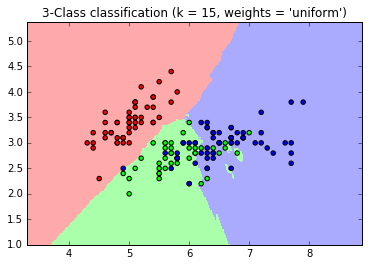

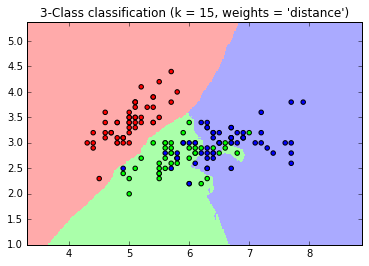

In [4]:
n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

In [6]:
df = pd.DataFrame(np.random.randn(6,4))

In [8]:
del df[0]

In [10]:
df.drop([1,2], axis = 1)

,3
0,-1.569206
1,1.124476
2,-0.349729
3,-0.343399
4,0.035397
5,-1.374534


In [12]:
df.drop(0, axis = 0)

,1,2,3
1,-2.066191,1.395033,1.124476
2,-1.435498,0.916762,-0.349729
3,-0.702570,0.792275,-0.343399
4,-0.692274,0.054867,0.035397
5,0.325861,-0.046116,-1.374534


In [13]:
df

,1,2,3
0,1.619917,-1.866857,-1.569206
1,-2.066191,1.395033,1.124476
2,-1.435498,0.916762,-0.349729
3,-0.702570,0.792275,-0.343399
4,-0.692274,0.054867,0.035397
5,0.325861,-0.046116,-1.374534


In [14]:
df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                     'foo', 'bar', 'foo', 'foo'],
                    'B' : ['one', 'one', 'two', 'three',
                           'two', 'two', 'one', 'three'],
               'C' : np.random.randn(8),
                  'D' : np.random.randn(8)})

In [15]:
df

,A,B,C,D
0,foo,one,-0.347863,-0.069466
1,bar,one,-0.469117,-2.533820
2,foo,two,0.107545,0.640042
3,bar,three,-1.784074,-1.192285
4,foo,two,-0.963568,-0.585259
5,bar,two,-1.731198,-0.838760
6,foo,one,-1.493573,0.104133
7,foo,three,-0.750973,-0.871977


In [27]:
df

,A,B,C,D
0,foo,one,-0.347863,-0.069466
1,bar,one,-0.469117,-2.533820
2,foo,two,0.107545,0.640042
3,bar,three,-1.784074,-1.192285
4,foo,two,-0.963568,-0.585259
5,bar,two,-1.731198,-0.838760
6,foo,one,-1.493573,0.104133
7,foo,three,-0.750973,-0.871977


In [31]:
df[['A','C']].groupby(['A']).sum()

,C
A,
bar,-3.984388
foo,-3.448432


In [29]:
df[['A','C']].groupby(['A']).mean()

,C
A,
bar,-1.328129
foo,-0.689686


In [32]:
 s = pd.Series(list('abca'))

In [33]:
s

0    a
1    b
2    c
3    a
dtype: object

In [41]:
ix3 = pd.MultiIndex.from_arrays([['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar']], \
                                names=['letter', 'word'])
df3 = pd.DataFrame({'data1': [3, 2, 4, 3, 2, 4, 3, 2], 'data2': [6, 5, 7, 5, 4, 5, 6, 5]}, index=ix3)
gp3 = df3.groupby(level=('letter', 'word'))

In [45]:
gp3.mean()

data1  data2
letter word              
a      bar     3.5    6.0
       foo     2.5    5.5
b      bar     2.5    5.5
       foo     3.0    4.5

In [48]:
gp3.std()

data1     data2
letter word                    
a      bar   0.707107  1.414214
       foo   0.707107  0.707107
b      bar   0.707107  0.707107
       foo   1.414214  0.707107

In [46]:
gp3.tail()

data1  data2
letter word              
a      foo       3      6
       foo       2      5
       bar       4      7
       bar       3      5
b      foo       2      4
       foo       4      5
       bar       3      6
       bar       2      5

In [54]:
fig?

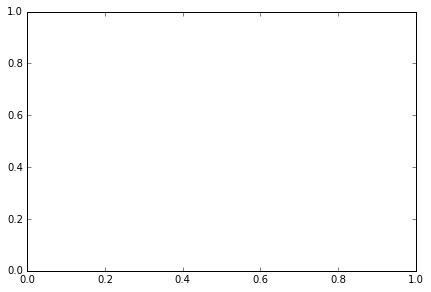

In [61]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])

(-0.4, 2)

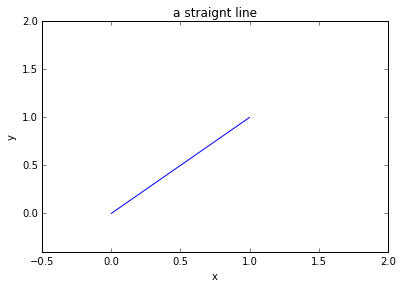

In [91]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])

a = ax1.plot([0, 1], [0,1])
title = ax1.set_title('a straignt line')
x_label = ax1.set_xlabel('x')
y_label = ax1.set_ylabel('y')

#ax2 = fig1.add_axes([0.2, 0.2, 0.6, 0.6]) #ax2会覆盖ax1

ax1.set_xlim(-0.5, 2)
ax1.set_ylim(-0.4, 2)

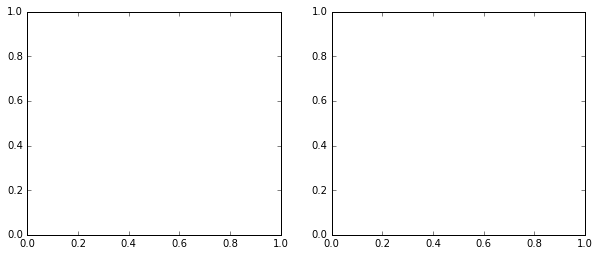

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4))

In [82]:
fig1.axes[0]

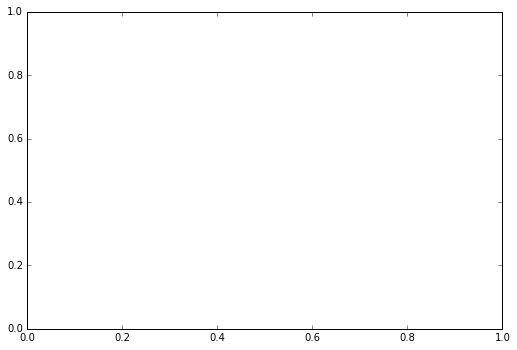

In [63]:
fig2 = plt.figure()
ax2 = fig2.add_axes([0.1, 0.1, 1.1, 1.1])

In [107]:
df = pd.DataFrame({'a':[1, 2,3, 4,4, 5,5]})

In [110]:
df

,a
0,1
1,2
2,3
3,4
4,4
5,5
6,5


In [111]:
pd.get_dummies(df)

,a
0,1
1,2
2,3
3,4
4,4
5,5
6,5


In [112]:
pd.get_dummies(df['a'])

,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0


In [113]:
import sklearn as skl

In [114]:
skl.setup_module

<function sklearn.setup_module>

In [2]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

In [2]:
##################################
#logistic regression

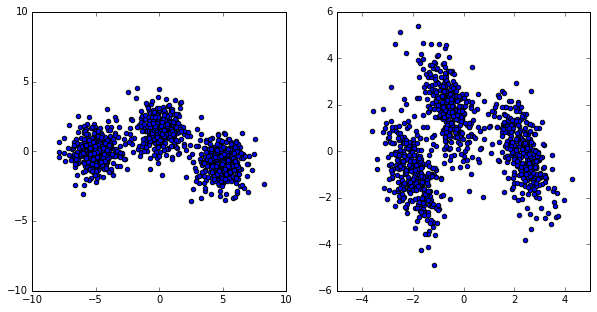

In [3]:
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = sklearn.datasets.make_blobs(n_samples=1000, centers=centers, random_state=40)

transformation = [[0.4, 0.2], [-0.4, 1.2]]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5))
sca1 = ax1.scatter(X[:, 0], X[:, 1])
ax1.set_xlim(-10,10)
ax1.set_ylim(-10,10)
X1 = np.dot(X, transformation)
sca2 = ax2.scatter(X1[:, 0], X1[:, 1])

training score : 0.976 (ovr)


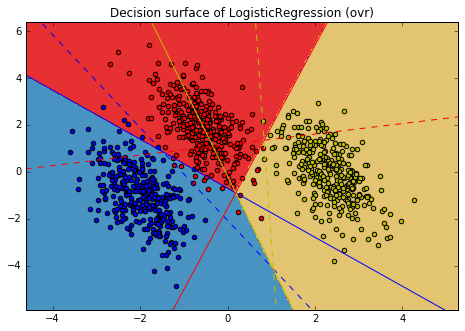

In [101]:
logreg = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                         multi_class='ovr')
clf = logreg.fit(X1, y)
print 'training score : %.3f (%s)' % (clf.score(X1, y), 'ovr')

h = .02  # step size in the mesh
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

fig = plt.figure()
axis = fig.add_axes([0,0,1,1])
axis.contourf(xx, yy, Z, cmap=plt.cm.Paired)
axis.set_title("Decision surface of LogisticRegression (%s)" % 'ovr')
axis.set_xlim(x_min, x_max)
axis.set_ylim(y_min, y_max)
axis.scatter(X1[y==0, 0], X1[y==0, 1], c = 'b')
axis.scatter(X1[y==1, 0], X1[y==1, 1], c = 'r')
axis.scatter(X1[y==2, 0], X1[y==2, 1], c = 'y')

x_hyp = np.arange(x_min, x_max, h)
y_hyp = (-1 * x_hyp * logreg.coef_[0, 0] - logreg.intercept_[0]) / logreg.coef_[0, 1]
axis.plot(x_hyp, y_hyp, ls = '--', c = 'b')
#x_hyp = np.arange(x_min, x_max, h)
y_hyp = (-1 * x_hyp * logreg.coef_[1, 0] - logreg.intercept_[1]) / logreg.coef_[1, 1]
axis.plot(x_hyp, y_hyp, ls = '--', c = 'r')
x_hyp = np.arange(x_min, x_max, h)
y_hyp = (-1 * x_hyp * logreg.coef_[2, 0] - logreg.intercept_[2]) / logreg.coef_[2, 1]
axis.plot(x_hyp, y_hyp, ls = '--', c = 'y')

y_hyp = (-1 * (logreg.coef_[0, 0] - logreg.coef_[1, 0]) * x_hyp - (logreg.intercept_[0] - logreg.intercept_[1])) \
            / (logreg.coef_[0, 1] - logreg.coef_[1,1])
axis.plot(x_hyp, y_hyp, ls = '-', c = 'b')

y_hyp = (-1 * (logreg.coef_[0, 0] - logreg.coef_[2, 0]) * x_hyp - (logreg.intercept_[0] - logreg.intercept_[2])) \
            / (logreg.coef_[0, 1] - logreg.coef_[2,1])
axis.plot(x_hyp, y_hyp, ls = '-', c = 'y')

y_hyp = (-1 * (logreg.coef_[2, 0] - logreg.coef_[1, 0]) * x_hyp - (logreg.intercept_[2] - logreg.intercept_[1])) \
            / (logreg.coef_[2, 1] - logreg.coef_[1,1])
axis.plot(x_hyp, y_hyp, ls = '-', c = 'r')
#图说明
#虚线是一对多的决策边界，由系数决定的边界
#首先两两之间的决策边界

In [95]:
logreg.intercept_

array([-4.61020975, -1.91396323, -4.17213317])

In [86]:
logreg.coef_

array([[-4.41615534, -2.23077034],
       [-0.36796618,  1.64022091],
       [ 4.7027708 ,  0.18133443]])

In [157]:
exp1 = 1.0 / (1 + np.exp(-1 * test1[0, 0] * logreg.coef_[0,0] -  test1[0, 1] * logreg.coef_[0, 1] - logreg.intercept_[0]))
exp2 = 1.0 / (1 + np.exp(-1 * test1[0, 0] * logreg.coef_[1,0] -  test1[0, 1] * logreg.coef_[1, 1] - logreg.intercept_[1]))
exp3 = 1.0 / (1 + np.exp(-1 * test1[0, 0] * logreg.coef_[2,0] -  test1[0, 1] * logreg.coef_[2, 1] - logreg.intercept_[2]))
print exp1, exp2, exp3
print exp1 / (exp1 + exp2 + exp3)
print exp2 / (exp1 + exp2 + exp3)
print exp3 / (exp1 + exp2 + exp3)

0.00511543749812 0.104183805168 0.0373372213794
0.0348851667382
0.710490435282
0.25462439798


In [156]:
# 测试某样本属于各个类的概率之和是否不为1，原本不为1的，这里强行置1
test1 = np.array([[0.2, -0.1]])
prob = logreg.predict_proba(test1)
y_label = logreg.predict(test1)
print prob, y_label
print prob.sum()

[[ 0.03488517  0.71049044  0.2546244 ]] [1]
1.0


training score : 0.995 (multinomial)


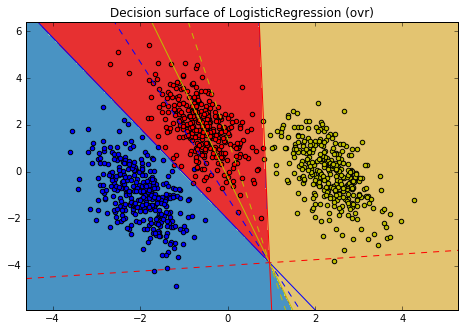

In [4]:
logreg1 = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                         multi_class='multinomial')
clf = logreg1.fit(X1, y)
print 'training score : %.3f (%s)' % (clf.score(X1, y), 'multinomial')

h = .02  # step size in the mesh
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

fig = plt.figure()
axis = fig.add_axes([0,0,1,1])
axis.contourf(xx, yy, Z, cmap=plt.cm.Paired)
axis.set_xlim(x_min, x_max)
axis.set_ylim(y_min, y_max)
axis.set_title("Decision surface of LogisticRegression (%s)" % 'ovr')
axis.scatter(X1[y==0, 0], X1[y==0, 1], c = 'b')
axis.scatter(X1[y==1, 0], X1[y==1, 1], c = 'r')
axis.scatter(X1[y==2, 0], X1[y==2, 1], c = 'y')

x_hyp = np.arange(x_min, x_max, h)
y_hyp = (-1 * x_hyp * logreg1.coef_[0, 0] - logreg1.intercept_[0]) / logreg1.coef_[0, 1]
axis.plot(x_hyp, y_hyp, ls = '--', c = 'b')
#x_hyp = np.arange(x_min, x_max, h)
y_hyp = (-1 * x_hyp * logreg1.coef_[1, 0] - logreg1.intercept_[1]) / logreg1.coef_[1, 1]
axis.plot(x_hyp, y_hyp, ls = '--', c = 'r')
x_hyp = np.arange(x_min, x_max, h)
y_hyp = (-1 * x_hyp * logreg1.coef_[2, 0] - logreg1.intercept_[2]) / logreg1.coef_[2, 1]
axis.plot(x_hyp, y_hyp, ls = '--', c = 'y')
#由系数决定的边界本身就交于一点，虚线所示
y_hyp = (-1 * (logreg1.coef_[0, 0] - logreg1.coef_[1, 0]) * x_hyp - (logreg1.intercept_[0] - logreg1.intercept_[1])) \
            / (logreg1.coef_[0, 1] - logreg1.coef_[1,1])
axis.plot(x_hyp, y_hyp, ls = '-', c = 'b')

#return
y_hyp = (-1 * (logreg1.coef_[0, 0] - logreg1.coef_[2, 0]) * x_hyp - (logreg1.intercept_[0] - logreg1.intercept_[2])) \
            / (logreg1.coef_[0, 1] - logreg1.coef_[2,1])
axis.plot(x_hyp, y_hyp, ls = '-', c = 'y')

y_hyp = (-1 * (logreg1.coef_[2, 0] - logreg1.coef_[1, 0]) * x_hyp - (logreg1.intercept_[2] - logreg1.intercept_[1])) \
            / (logreg1.coef_[2, 1] - logreg1.coef_[1,1])
axis.plot(x_hyp, y_hyp, ls = '-', c = 'r')

In [102]:
logreg1.intercept_

array([-1.69953772,  2.89754216, -1.19800443])

In [87]:
logreg1.coef_

array([[-4.51827313, -1.56106962],
       [-0.08860005,  0.72634754],
       [ 4.60687318,  0.83472208]])

In [151]:
# 测试某样本属于各个类的概率之和是否为1
test1 = np.array([[1, ]])
prob = logreg1.predict_proba(test1)
y_label = logreg1.predict(test1)
print prob, y_label
print prob.sum()

exp1 = np.exp(test1[0, 0] * logreg1.coef_[0, 0] + test1[0, 1] * logreg1.coef_[0, 1] + logreg1.intercept_[0])
exp2 = np.exp(test1[0, 0] * logreg1.coef_[1, 0] + test1[0, 1] * logreg1.coef_[1, 1] + logreg1.intercept_[1])
exp3 = np.exp(test1[0, 0] * logreg1.coef_[2, 0] + test1[0, 1] * logreg1.coef_[2, 1] + logreg1.intercept_[2])
print exp1 / (exp1 + exp2 + exp3)
print exp2 / (exp1 + exp2 + exp3)
print exp3 / (exp1 + exp2 + exp3)

[[  3.57029663e-08   2.83929983e-01   7.16069981e-01]] [2]
1.0
3.57029663321e-08
0.283929983123
0.716069981174


In [109]:
a = x.ravel()

In [35]:
a.shape = (1,9)

In [36]:
a

array([[1, 2, 3, 1, 2, 3, 1, 2, 3]])